# Method 4 - Rest Ideas After 1

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Market Cap Adjusted Target

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance Adjusted Intra-Cap Weight Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data[
    'weight'].fillna(0)) * valid_data['capm_var']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 1].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

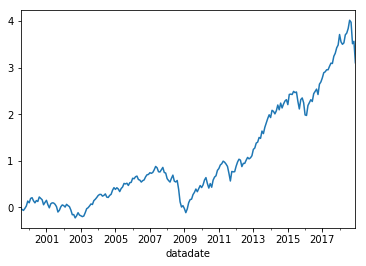

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.134562
2000-12-31   -0.025451
2001-12-31   -0.048954
2002-12-31   -0.206866
2003-12-31    0.451845
2004-12-31    0.175192
2005-12-31    0.080166
2006-12-31    0.110138
2007-12-31    0.017375
2008-12-31   -0.403168
2009-12-31    0.417111
2010-12-31    0.222082
2011-12-31   -0.015870
2012-12-31    0.193712
2013-12-31    0.417051
2014-12-31    0.108829
2015-12-31   -0.020133
2016-12-31    0.137628
2017-12-31    0.214655
2018-12-31   -0.084913
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2940.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.70e-195
Time:                        12:27:28   Log-Likelihood:                 841.14
No. Observations:                 234   AIC:                            -1672.
Df Residuals:                     229   BIC:                            -1655.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.621      0.000       0.001       0.003
mktrf          1.0100      0.013     80.596      0.000       0.985       1.035
me             0.2738      0.015     18.786      0.000       0.245       0.303
ia             0.0522      0.022      2.356      0.019       0.009       0.096
roe           -0.0282      0.019     -1.486      0.139      -0.066       0.009
==============================================================================
Omnibus:                       27.602   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.083
Skew:                          -0.167   Prob(JB):                     1.04e-30
Kurtosis:                       6.748   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1754.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.91e-170
Time:                        12:27:28   Log-Likelihood:                 841.14
No. Observations:                 234   AIC:                            -1672.
Df Residuals:                     229   BIC:                            -1655.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.768      0.000       0.001       0.003
mktrf          1.0100      0.016     63.347      0.000       0.979       1.041
me             0.2738      0.023     12.088      0.000       0.229       0.318
ia             0.0522      0.045      1.153      0.249      -0.037       0.141
roe           -0.0282      0.026     -1.076      0.282      -0.080       0.023
==============================================================================
Omnibus:                       27.602   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.083
Skew:                          -0.167   Prob(JB):                     1.04e-30
Kurtosis:                       6.748   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2138.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.31e-180
Time:                        12:27:28   Log-Likelihood:                 841.14
No. Observations:                 234   AIC:                            -1672.
Df Residuals:                     229   BIC:                            -1655.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      5.155      0.000       0.001       0.003
mktrf          1.0100      0.016     65.137      0.000       0.980       1.040
me             0.2738      0.021     12.846      0.000       0.232       0.316
ia             0.0522      0.047      1.105      0.269      -0.040       0.145
roe           -0.0282      0.029     -0.960      0.337      -0.086       0.029
==============================================================================
Omnibus:                       27.602   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.083
Skew:                          -0.167   Prob(JB):                     1.04e-30
Kurtosis:                       6.748   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1968.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.65e-185
Time:                        12:27:28   Log-Likelihood:                 821.21
No. Observations:                 234   AIC:                            -1630.
Df Residuals:                     228   BIC:                            -1610.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.723      0.000       0.001       0.003
mktrf          1.0217      0.014     74.557      0.000       0.995       1.049
smb            0.2984      0.018     16.505      0.000       0.263       0.334
hml            0.0185      0.021      0.869      0.386      -0.023       0.061
rmw           -0.0113      0.024     -0.470      0.639      -0.059       0.036
cma            0.0466      0.031      1.521      0.130      -0.014       0.107
==============================================================================
Omnibus:                       27.272   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.830
Skew:                           0.003   Prob(JB):                     1.31e-32
Kurtosis:                       6.881   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1552.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.44e-174
Time:                        12:27:28   Log-Likelihood:                 821.21
No. Observations:                 234   AIC:                            -1630.
Df Residuals:                     228   BIC:                            -1610.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.564      0.000       0.001       0.003
mktrf          1.0217      0.018     58.321      0.000       0.987       1.056
smb            0.2984      0.023     13.102      0.000       0.254       0.343
hml            0.0185      0.048      0.383      0.702      -0.076       0.113
rmw           -0.0113      0.028     -0.407      0.684      -0.066       0.043
cma            0.0466      0.051      0.917      0.359      -0.053       0.146
==============================================================================
Omnibus:                       27.272   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.830
Skew:                           0.003   Prob(JB):                     1.31e-32
Kurtosis:                       6.881   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2148.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.56e-189
Time:                        12:27:28   Log-Likelihood:                 821.21
No. Observations:                 234   AIC:                            -1630.
Df Residuals:                     228   BIC:                            -1610.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.555      0.000       0.001       0.003
mktrf          1.0217      0.017     60.671      0.000       0.989       1.055
smb            0.2984      0.023     13.080      0.000       0.254       0.343
hml            0.0185      0.051      0.361      0.718      -0.082       0.119
rmw           -0.0113      0.030     -0.376      0.707      -0.070       0.048
cma            0.0466      0.050      0.935      0.350      -0.051       0.144
==============================================================================
Omnibus:                       27.272   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.830
Skew:                           0.003   Prob(JB):                     1.31e-32
Kurtosis:                       6.881   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2211.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.21e-181
Time:                        12:27:28   Log-Likelihood:                 808.54
No. Observations:                 234   AIC:                            -1607.
Df Residuals:                     229   BIC:                            -1590.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.950      0.000       0.001       0.003
mktrf          1.0180      0.013     76.756      0.000       0.992       1.044
smb            0.2865      0.017     17.302      0.000       0.254       0.319
hml            0.0898      0.016      5.459      0.000       0.057       0.122
umd           -0.0062      0.011     -0.578      0.564      -0.027       0.015
==============================================================================
Omnibus:                       28.834   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.457
Skew:                           0.043   Prob(JB):                     7.15e-37
Kurtosis:                       7.131   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1886.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.09e-174
Time:                        12:27:28   Log-Likelihood:                 808.54
No. Observations:                 234   AIC:                            -1607.
Df Residuals:                     229   BIC:                            -1590.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.324      0.001       0.001       0.003
mktrf          1.0180      0.018     55.176      0.000       0.982       1.054
smb            0.2865      0.024     12.159      0.000       0.240       0.333
hml            0.0898      0.049      1.841      0.066      -0.006       0.185
umd           -0.0062      0.020     -0.313      0.754      -0.045       0.033
==============================================================================
Omnibus:                       28.834   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.457
Skew:                           0.043   Prob(JB):                     7.15e-37
Kurtosis:                       7.131   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2461.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.80e-187
Time:                        12:27:28   Log-Likelihood:                 808.54
No. Observations:                 234   AIC:                            -1607.
Df Residuals:                     229   BIC:                            -1590.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.304      0.001       0.001       0.003
mktrf          1.0180      0.016     64.439      0.000       0.987       1.049
smb            0.2865      0.025     11.638      0.000       0.238       0.335
hml            0.0898      0.054      1.656      0.098      -0.016       0.196
umd           -0.0062      0.016     -0.388      0.698      -0.038       0.025
==============================================================================
Omnibus:                       28.834   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.457
Skew:                           0.043   Prob(JB):                     7.15e-37
Kurtosis:                       7.131   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1309.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.23e-95
Time:                        12:27:28   Log-Likelihood:                 412.43
No. Observations:                 120   AIC:                            -814.9
Df Residuals:                     115   BIC:                            -800.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.497      0.001       0.001       0.004
mktrf          1.0176      0.020     49.657      0.000       0.977       1.058
me             0.2567      0.020     12.684      0.000       0.217       0.297
ia             0.0892      0.032      2.815      0.006       0.026       0.152
roe           -0.0224      0.028     -0.798      0.426      -0.078       0.033
==============================================================================
Omnibus:                       11.358   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               29.912
Skew:                          -0.120   Prob(JB):                     3.20e-07
Kurtosis:                       5.434   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1026.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.24e-89
Time:                        12:27:28   Log-Likelihood:                 412.43
No. Observations:                 120   AIC:                            -814.9
Df Residuals:                     115   BIC:                            -800.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.598      0.000       0.001       0.004
mktrf          1.0176      0.027     37.693      0.000       0.965       1.070
me             0.2567      0.023     10.926      0.000       0.211       0.303
ia             0.0892      0.050      1.799      0.072      -0.008       0.186
roe           -0.0224      0.032     -0.703      0.482      -0.085       0.040
==============================================================================
Omnibus:                       11.358   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               29.912
Skew:                          -0.120   Prob(JB):                     3.20e-07
Kurtosis:                       5.434   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1577.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.04e-99
Time:                        12:27:29   Log-Likelihood:                 412.43
No. Observations:                 120   AIC:                            -814.9
Df Residuals:                     115   BIC:                            -800.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.723      0.000       0.001       0.004
mktrf          1.0176      0.024     43.017      0.000       0.971       1.064
me             0.2567      0.023     11.385      0.000       0.213       0.301
ia             0.0892      0.045      1.973      0.048       0.001       0.178
roe           -0.0224      0.033     -0.672      0.501      -0.088       0.043
==============================================================================
Omnibus:                       11.358   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               29.912
Skew:                          -0.120   Prob(JB):                     3.20e-07
Kurtosis:                       5.434   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     837.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.18e-88
Time:                        12:27:29   Log-Likelihood:                 399.87
No. Observations:                 120   AIC:                            -787.7
Df Residuals:                     114   BIC:                            -771.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.356      0.001       0.001       0.005
mktrf          1.0573      0.024     43.876      0.000       1.010       1.105
smb            0.2968      0.027     10.876      0.000       0.243       0.351
hml           -0.0057      0.033     -0.171      0.864      -0.072       0.061
rmw            0.0239      0.039      0.605      0.546      -0.054       0.102
cma            0.1103      0.043      2.554      0.012       0.025       0.196
==============================================================================
Omnibus:                       12.818   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               37.184
Skew:                          -0.157   Prob(JB):                     8.43e-09
Kurtosis:                       5.709   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     957.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.56e-91
Time:                        12:27:29   Log-Likelihood:                 399.87
No. Observations:                 120   AIC:                            -787.7
Df Residuals:                     114   BIC:                            -771.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.341      0.001       0.001       0.005
mktrf          1.0573      0.034     31.298      0.000       0.991       1.123
smb            0.2968      0.035      8.439      0.000       0.228       0.366
hml           -0.0057      0.079     -0.072      0.942      -0.161       0.149
rmw            0.0239      0.060      0.400      0.689      -0.093       0.141
cma            0.1103      0.063      1.759      0.079      -0.013       0.233
==============================================================================
Omnibus:                       12.818   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               37.184
Skew:                          -0.157   Prob(JB):                     8.43e-09
Kurtosis:                       5.709   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1715.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.71e-105
Time:                        12:27:29   Log-Likelihood:                 399.87
No. Observations:                 120   AIC:                            -787.7
Df Residuals:                     114   BIC:                            -771.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.501      0.000       0.001       0.005
mktrf          1.0573      0.032     32.855      0.000       0.994       1.120
smb            0.2968      0.036      8.299      0.000       0.227       0.367
hml           -0.0057      0.085     -0.067      0.946      -0.173       0.161
rmw            0.0239      0.065      0.367      0.714      -0.104       0.151
cma            0.1103      0.062      1.787      0.074      -0.011       0.231
==============================================================================
Omnibus:                       12.818   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               37.184
Skew:                          -0.157   Prob(JB):                     8.43e-09
Kurtosis:                       5.709   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     910.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.95e-86
Time:                        12:27:29   Log-Likelihood:                 391.19
No. Observations:                 120   AIC:                            -772.4
Df Residuals:                     115   BIC:                            -758.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.821      0.000       0.002       0.005
mktrf          1.0307      0.022     47.832      0.000       0.988       1.073
smb            0.2766      0.025     11.273      0.000       0.228       0.325
hml            0.1102      0.025      4.486      0.000       0.062       0.159
umd           -0.0028      0.015     -0.183      0.855      -0.033       0.027
==============================================================================
Omnibus:                       13.787   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               45.798
Skew:                          -0.085   Prob(JB):                     1.14e-10
Kurtosis:                       6.022   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1300.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.07e-94
Time:                        12:27:29   Log-Likelihood:                 391.19
No. Observations:                 120   AIC:                            -772.4
Df Residuals:                     115   BIC:                            -758.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.971      0.000       0.002       0.005
mktrf          1.0307      0.030     34.764      0.000       0.973       1.089
smb            0.2766      0.028      9.937      0.000       0.222       0.331
hml            0.1102      0.061      1.797      0.072      -0.010       0.230
umd           -0.0028      0.024     -0.118      0.906      -0.049       0.044
==============================================================================
Omnibus:                       13.787   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               45.798
Skew:                          -0.085   Prob(JB):                     1.14e-10
Kurtosis:                       6.022   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2150.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.79e-107
Time:                        12:27:29   Log-Likelihood:                 391.19
No. Observations:                 120   AIC:                            -772.4
Df Residuals:                     115   BIC:                            -758.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.222      0.000       0.002       0.005
mktrf          1.0307      0.023     45.217      0.000       0.986       1.075
smb            0.2766      0.029      9.549      0.000       0.220       0.333
hml            0.1102      0.066      1.663      0.096      -0.020       0.240
umd           -0.0028      0.018     -0.154      0.877      -0.038       0.033
==============================================================================
Omnibus:                       13.787   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               45.798
Skew:                          -0.085   Prob(JB):                     1.14e-10
Kurtosis:                       6.022   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2528.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.82e-106
Time:                        12:27:29   Log-Likelihood:                 459.29
No. Observations:                 114   AIC:                            -908.6
Df Residuals:                     109   BIC:                            -894.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      4.023      0.000       0.001       0.003
mktrf          1.0027      0.013     77.450      0.000       0.977       1.028
me             0.3127      0.020     15.644      0.000       0.273       0.352
ia            -0.0803      0.028     -2.895      0.005      -0.135      -0.025
roe           -0.0943      0.024     -3.869      0.000      -0.143      -0.046
==============================================================================
Omnibus:                        9.621   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.536
Skew:                          -0.644   Prob(JB):                      0.00850
Kurtosis:                       3.590   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3907.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.11e-116
Time:                        12:27:29   Log-Likelihood:                 459.29
No. Observations:                 114   AIC:                            -908.6
Df Residuals:                     109   BIC:                            -894.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      4.076      0.000       0.001       0.003
mktrf          1.0027      0.010    103.848      0.000       0.984       1.022
me             0.3127      0.017     18.693      0.000       0.280       0.345
ia            -0.0803      0.031     -2.630      0.009      -0.140      -0.020
roe           -0.0943      0.025     -3.802      0.000      -0.143      -0.046
==============================================================================
Omnibus:                        9.621   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.536
Skew:                          -0.644   Prob(JB):                      0.00850
Kurtosis:                       3.590   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4587.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.89e-120
Time:                        12:27:29   Log-Likelihood:                 459.29
No. Observations:                 114   AIC:                            -908.6
Df Residuals:                     109   BIC:                            -894.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      3.818      0.000       0.001       0.003
mktrf          1.0027      0.009    110.532      0.000       0.985       1.020
me             0.3127      0.017     18.839      0.000       0.280       0.345
ia            -0.0803      0.034     -2.376      0.018      -0.147      -0.014
roe           -0.0943      0.023     -4.060      0.000      -0.140      -0.049
==============================================================================
Omnibus:                        9.621   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.536
Skew:                          -0.644   Prob(JB):                      0.00850
Kurtosis:                       3.590   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2848.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.69e-113
Time:                        12:27:29   Log-Likelihood:                 479.13
No. Observations:                 114   AIC:                            -946.3
Df Residuals:                     108   BIC:                            -929.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.463      0.015       0.000       0.002
mktrf          1.0079      0.010     96.707      0.000       0.987       1.029
smb            0.2865      0.017     16.932      0.000       0.253       0.320
hml            0.0046      0.022      0.213      0.832      -0.038       0.047
rmw           -0.1631      0.026     -6.171      0.000      -0.215      -0.111
cma           -0.0980      0.034     -2.923      0.004      -0.165      -0.032
==============================================================================
Omnibus:                       10.249   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.282
Skew:                          -0.685   Prob(JB):                      0.00585
Kurtosis:                       3.536   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3133.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.03e-115
Time:                        12:27:29   Log-Likelihood:                 479.13
No. Observations:                 114   AIC:                            -946.3
Df Residuals:                     108   BIC:                            -929.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.348      0.019       0.000       0.002
mktrf          1.0079      0.009    111.563      0.000       0.990       1.026
smb            0.2865      0.015     19.087      0.000       0.257       0.316
hml            0.0046      0.018      0.262      0.793      -0.030       0.039
rmw           -0.1631      0.022     -7.479      0.000      -0.206      -0.120
cma           -0.0980      0.035     -2.830      0.005      -0.166      -0.030
==============================================================================
Omnibus:                       10.249   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.282
Skew:                          -0.685   Prob(JB):                      0.00585
Kurtosis:                       3.536   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5307.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.05e-127
Time:                        12:27:29   Log-Likelihood:                 479.13
No. Observations:                 114   AIC:                            -946.3
Df Residuals:                     108   BIC:                            -929.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.099      0.036    6.07e-05       0.002
mktrf          1.0079      0.008    131.535      0.000       0.993       1.023
smb            0.2865      0.014     21.119      0.000       0.260       0.313
hml            0.0046      0.016      0.287      0.774      -0.027       0.036
rmw           -0.1631      0.024     -6.881      0.000      -0.210      -0.117
cma           -0.0980      0.034     -2.859      0.004      -0.165      -0.031
==============================================================================
Omnibus:                       10.249   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.282
Skew:                          -0.685   Prob(JB):                      0.00585
Kurtosis:                       3.536   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2389.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.81e-105
Time:                        12:27:29   Log-Likelihood:                 456.10
No. Observations:                 114   AIC:                            -902.2
Df Residuals:                     109   BIC:                            -888.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.144      0.255      -0.000       0.001
mktrf          1.0210      0.013     80.929      0.000       0.996       1.046
smb            0.3236      0.020     16.448      0.000       0.285       0.363
hml           -0.0011      0.020     -0.055      0.956      -0.041       0.039
umd           -0.0242      0.015     -1.584      0.116      -0.055       0.006
==============================================================================
Omnibus:                        4.631   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                4.058
Skew:                          -0.438   Prob(JB):                        0.131
Kurtosis:                       3.294   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1817.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.65e-99
Time:                        12:27:29   Log-Likelihood:                 456.10
No. Observations:                 114   AIC:                            -902.2
Df Residuals:                     109   BIC:                            -888.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.064      0.288      -0.000       0.001
mktrf          1.0210      0.013     76.191      0.000       0.995       1.047
smb            0.3236      0.017     18.858      0.000       0.290       0.357
hml           -0.0011      0.018     -0.062      0.951      -0.036       0.034
umd           -0.0242      0.011     -2.188      0.029      -0.046      -0.003
==============================================================================
Omnibus:                        4.631   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                4.058
Skew:                          -0.438   Prob(JB):                        0.131
Kurtosis:                       3.294   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2918.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.91e-110
Time:                        12:27:29   Log-Likelihood:                 456.10
No. Observations:                 114   AIC:                            -902.2
Df Residuals:                     109   BIC:                            -888.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.040      0.298      -0.000       0.001
mktrf          1.0210      0.013     80.443      0.000       0.996       1.046
smb            0.3236      0.013     24.846      0.000       0.298       0.349
hml           -0.0011      0.015     -0.075      0.940      -0.030       0.028
umd           -0.0242      0.011     -2.304      0.021      -0.045      -0.004
==============================================================================
Omnibus:                        4.631   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                4.058
Skew:                          -0.438   Prob(JB):                        0.131
Kurtosis:                       3.294   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""